# Solving Problems by Searching

In [62]:
# import libraries
from search import * 
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

# hide matplotlib warnings 
import warnings 
warnings.filterwarnings("ignore")

import timeit

# Contents
* Overview
* Problem
* Node
* Simple Problem Solving Agent
* Search Algorithms Visualization
* Breadth-First Tree Search
* Breadth-First Search
* Best First Search
* Uniform Cost Search
* Greedy Best First Search
* A* Search
* Hill Climbing
* Simulated Annealing
* Genetic Algorithm
* AND-OR Graph Search
* Online DFS Agent
* LRTA* Agent


# Overview

Here, we learn about a specific kind of problem solving - building goal-based agents that can plan ahead to solve problems. In particular, we examine navigation problem/route finding problem. We must begin by precisely defining problems and their solutions. We will look at several general-purpose search algorithms.

Search algorithms can be classified into two types:

* Uninformed search algorithms: Search algorithms which explore the search space without having any information about the problem other than its definition.
    * Examples:
        1. Breadth First Search
        2. Depth First Search
        3. Depth Limited Search
        4. Iterative Deepening Search
        5. Informed search algorithms: These type of algorithms leverage any information (heuristics, path cost) on the problem to search through the search space to find the solution efficiently.
    * Examples:
        1. Best First Search
        2. Uniform Cost Search
        3. A* Search
        4. Recursive Best First Search

For visualisations, we use networkx and matplotlib to show the map in the notebook and we use ipywidgets to interact with the map to see how the searching algorithm works. These are imported as required in notebook.py.

In [5]:
%matplotlib inline 
import networkx as nx 
import matplotlib.pyplot as plt 
from matplotlib import lines 
from ipywidgets import interact 
import ipywidgets as widgets 
from IPython.display import display 
import time

In [6]:
# see definition of problem 
psource(Problem)

The Problem class has 6 methods: 

* init - constructor 
* actions - returns all possible actions an agent can execute in a given state 
* result - returns the resulting state if action action is taken in state state. This only deals with deterministic outcomes, so we know for sure what every action in a state would result to. 
* goal_test - return a boolean for a given state - True is goal state, false ow
* path_Cost : retuen the cost of the path that arrives at state2 as a result of taking action from state1, assuming total cost of c to get up to state1
* value - acts as extra information in problems where we try to optimize a value when we cannot do a goal test 

In [7]:
# see how Node is defined 
psource(Node)

The Node class has nine methods: 

* init : constructor. Creates a node, parent represents the node that this is a successor of and action is the action required to get from the parent node to this node. path_cost is the cost to reach the current node from the parent node. 
* expand: lists all the neighboring (reachable in 1 step) nodes of the current node
* child_node: given an action, returns the immediate neighbor that can be reached with that action 
* solution: returns the sequence of actions required to reach this node from the root node 
* path: returns a list of all the nodes that lie in the path from the root to this node 

The remaining methods override standard python functionality for representing an object as a string, the less than operator, the equal to operator and the hash function 

* __repr__ : returns that state of the node 
* __lt__ : given a node, returns true if the current state is less than another node's state. False ow
* __eq__ : returns true if the state of the current node is equal to another node, false ow
* __hash__ : returns the hash of the state of the current node 



In [8]:
# definition of GraphProblem
psource(GraphProblem)

The GraphProblem class has 6 methods. 

* init : a constructor. takes a goal node, initial node, and a graph 
* actions : returns a list of actions available given a state. These are its neighbors
* result : returns the result of going to a neighbor 
* path_cost : returns the cost of the path of nodes explored from root to the current node 
* h : returns the straight line distance from a node's state to its goal 


In [9]:
# look at map of Romania

romania_map = UndirectedGraph(dict(
    Arad = dict(Zerind = 75, Sibiu = 140, Timisoara = 118),
    Bucharest = dict(Urziceni = 85, Pitesti = 101, Giurgiu = 90, Fagaras = 211),
    Craiova = dict(Drobeta = 120, Rimnicu = 146, Pitesti = 138),
    Drobeta = dict(Mehadia = 75),
    Eforie = dict(Hirsova = 86),
    Fagaras = dict(Sibiu = 99),
    Hirsova = dict(Urziceni = 98),
    Iasi = dict(Vaslui = 92, Neamt = 87),
    Lugoj = dict(Timisoara = 111, Mehadia = 70),
    Oradea = dict(Zerind = 71, Sibiu = 151),
    Pitesti = dict(Rimnicu = 97),
    Rimnicu = dict(Sibiu = 80),
    Urziceni = dict(Vaslui = 142)))

romania_map.locations = dict(
    Arad = (91, 492), Bucharest = (400, 327), Craiova = (253, 288),
    Drobeta = (165, 299), Eforie = (562, 293), Fagaras = (305, 449),
    Giurgiu = (375, 270), Hirsova = (534, 350), Iasi = (473, 506),
    Lugoj = (165, 379), Mehadia = (168, 339), Neamt = (406, 537),
    Oradea = (131, 571), Pitesti = (320, 368), Rimnicu = (233, 410),
    Sibiu = (207, 457), Timisoara = (94, 410), Urziceni = (456, 350),
    Vaslui = (509, 444), Zerind = (108, 531))

It is pretty straightforward to understand this romania_map. The first node Arad has three neighbours named Zerind, Sibiu, Timisoara. Each of these nodes are 75, 140, 118 units apart from Arad respectively. And the same goes with other nodes.

And romania_map.locations contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in romania_map) between two cities in algorithms like A*-search and Recursive Best First Search.

Define a problem: Now it's time to define our problem. We will define it by passing initial, goal, graph to GraphProblem. So, our problem is to find the goal state starting from the given initial state on the provided graph.

In [10]:
# starting from Arad, try to find Bucharest
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)


In [11]:
# have a look at romania_locations 
romania_locations = romania_map.locations 
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Now we can initialize an empty graph, add nodes, place the nodes in their locations and add edges to the graph 

In [12]:
# node colors, positions, and labels 
node_colors = {node: 'white' for node in romania_map.locations.keys()} 
node_positions = romania_map.locations
node_label_pos = {k:[v[0], v[1]-10] for k, v in romania_map.locations.items()}
edge_weights = {(k, k2):v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

# define graph 
romania_graph_data = {'graph_dict' : romania_map.graph_dict, 
                      'node_colors' : node_colors,
                      'node_positions' : node_positions, 
                      'node_label_positions' : node_label_pos, 
                      'edge_weights' : edge_weights}

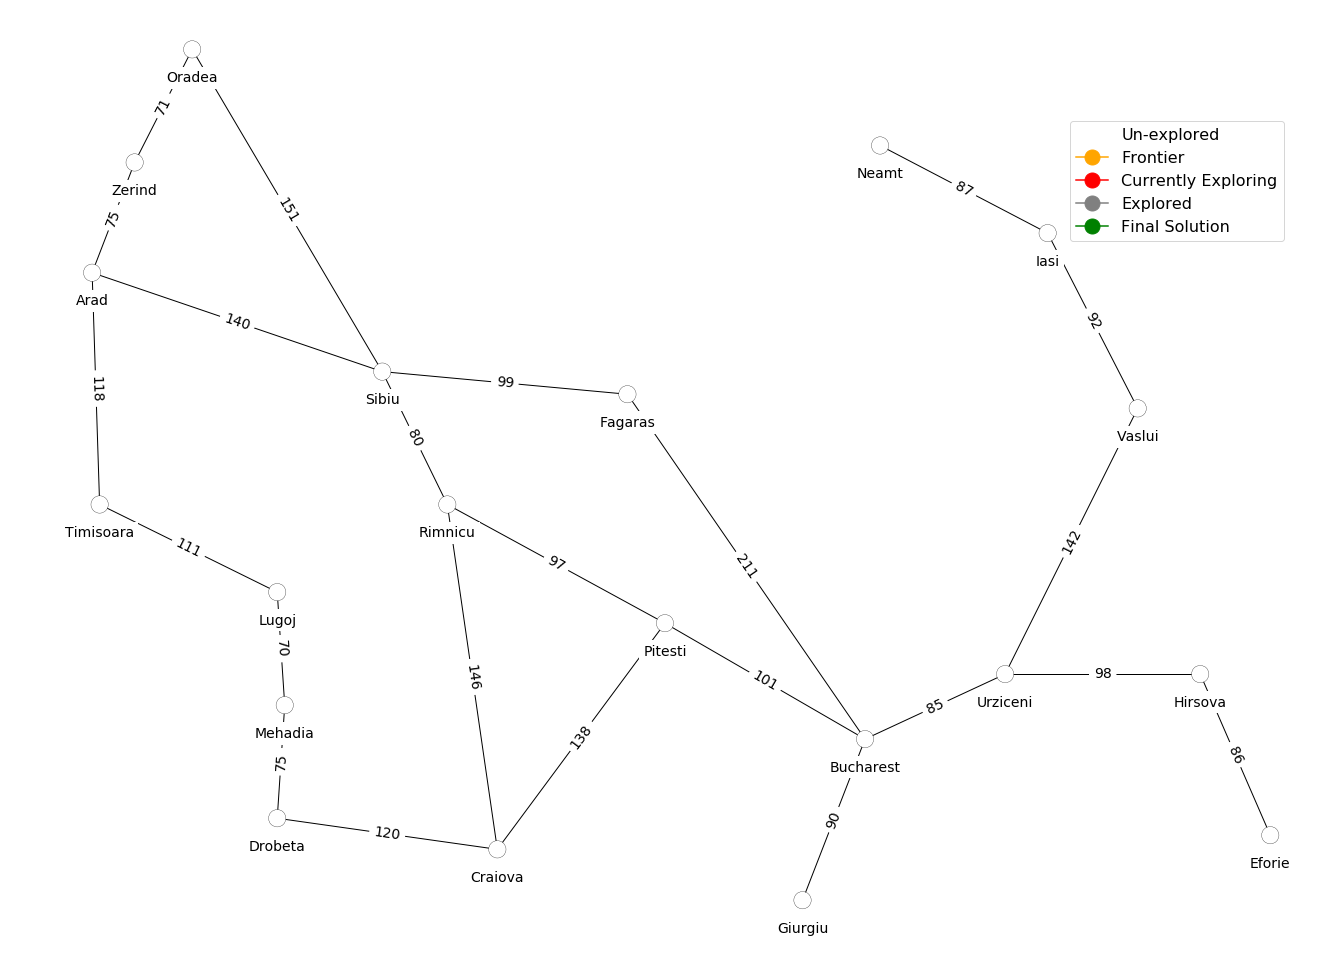

In [13]:
# Now that we have built our graph, lets display it! 
show_map(romania_graph_data)

# Simple Problem Solving Agent Program

In [14]:
# view class for simple problem solving agent program 
psource(SimpleProblemSolvingAgentProgram)

The SimpleProblemSolvingAgentProgram class has six methods: 

* __init__: constructor. It takes a keyword argument, initial_state which is None by default. This represents the state from which the agent starts. 
* __call__(self, percept): updates the state of the agent based on its percept using the update_state method. It then formulates a goal with the help of formulate_goal method and problem using the formulate_problem method. Then it returns a sequence of actions to solve it  using the search method. 
* update_state(self, percept): updates the state based on the percept 
* formulate_goal(self, state): given a state of the agent, formulate a goal 
* formulate_problem(self, state, goal): given a state and goal, formulate a problem 
* search(self, problem): search a sequence of actions to solve a problem 

We will now define a simple problem solving agent program. 

![](https://github.com/aimacode/aima-python/raw/fb9b85a7b87091484e4b7e96aaec972598a1696d/images/simple_problem_solving_agent.jpg)

In [15]:
class VacuumAgent(SimpleProblemSolvingAgentProgram):
    def update_state(self, state, percept): 
        return percept 
    
    def formulate_goal(self, state): 
        goal = [state7, state8]
        return goal
    
    def formulate_problem(self, state, goal): 
        problem = state 
        return problem 
    
    def search(self, problem): 
        if problem == state1: 
            seq = ["Suck", "Right", "Suck"]
        elif problem == state2: 
            seq = ["Suck", "Left", "Suck"]
        elif problem == state3: 
            seq = ["Right", "Suck"]
        elif problem == state4: 
            seq = ["Suck"]
        elif problem == state5: 
            seq = ["Suck"]
        elif problem == state6: 
            seq = ["Left", "Suck"]
        return seq

In [16]:
# create objects of the above class 
state1 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state2 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state3 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state4 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state5 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state6 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state7 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]
state8 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]

a = VacuumAgent(state1)

print(a(state6)) 
print(a(state1))
print(a(state3))

Left
Suck
Right


# Search Algorithm Visualization

In this section, there are visualizations of the following search algorithms: 

1. Breadth First Tree Search 
2. Depth First Tree Search 
3. Breadth First Search 
4. Depth First Graph Search 
5. Best First Graph Search 
6. Uniform Cost Search 
7. Depth Limited Search 
8. Iterative Deepening Search 
9. Greedy Best First Search
10. A* Search
11. Recursive Best First Search

### Breadth First Tree Search

In [17]:
# Breadth First Tree Search 
def breadth_first_tree_search_vis(problem):
    '''Search through the successors of a problem to find a goal'''
    
    # declarations 
    iterations = 0
    all_node_colors = []
    node_colors = {k: 'white' for k in problem.graph.nodes()}
    
    # add first node to the queue 
    frontier = deque([Node(problem.initial)])
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    # loop through frontier nodes 
    while frontier: 
        # pop first node 
        node = frontier.popleft() 
        
        # modify current searching node to red 
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify the goal node to green once goal is reached 
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        # else expand frontier 
        frontier.extend(node.expand(problem))
        
        for n in node.expand(problem): 
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))
        
        # color explored nodes gray 
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    
    return None

In [19]:
def breadth_first_tree_search(problem): 
    iterations, all_node_colors, node = breadth_first_tree_search_vis(problem)
    return(iterations, all_node_colors, node)

In [20]:
# node colors list
all_node_colors = []

# define graph to explore
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

# call 3 different searches on graph
iter1, iter2, iter3 = breadth_first_tree_search(romania_problem)

# display 
display_visual(romania_graph_data, user_input = False, 
               algorithm = breadth_first_tree_search, problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Depth First Tree Search

In [21]:
def depth_first_tree_search_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    #Adding first node to the stack
    frontier = [Node(problem.initial)]
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of stack
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

In [23]:
def depth_first_tree_search(problem):
    "Search the deepest nodes in the search tree first."
    iterations, all_node_colors, node = depth_first_tree_search_vis(problem)
    return(iterations, all_node_colors, node)

In [24]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
               algorithm = depth_first_tree_search, 
               problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Breadth First Graph Search 

In [26]:
def breadth_first_graph_search(problem):
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    # add first node
    node = Node(problem.initial)
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    # goal found? 
    if problem.goal_test(node.state): 
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    # else expand frontier 
    frontier = deque([node])
    
    # modify color of frontier nodes 
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set() 
    
    while frontier: 
        node = frontier.popleft() 
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors)) 
        
        explored.add(node.state)
        
        for child in node.expand(problem): 
            if child.state not in explored and child not in frontier: 
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return(iterations, all_node_colors, child)
                frontier.append(child)
                
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
        
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    
    return None

In [27]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = breadth_first_graph_search, 
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Depth First Graph Search 

In [28]:
def depth_first_graph_search_vis(problem): 
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier = [(Node(problem.initial))]
    explored = set() 
    
    # make frontier nodes orange 
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier: 
        # pop first node 
        node = frontier.pop() 
        
        # make currently searching node red 
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reached 
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                       if child.state not in explored
                       and child not in frontier)
        
        for n in frontier:
            # modify the color of frontier nodes to orange 
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            
    return None

In [29]:
def depth_first_graph_search(problem): 
    iterations, all_node_colors, node = depth_first_graph_search_vis(problem)
    return(iterations, all_node_colors, node)

In [30]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = depth_first_graph_search, 
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Best First Search 

In [31]:
def best_first_graph_search_vis(problem, f): 
    '''
    Searches nodes with the lowest f scores first. 
    Specify the function f(node) that we wish to minimize
    '''
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    # dynamic programming 
    f = memoize(f, 'f')
    
    # initialize
    node = Node(problem.initial)
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    # if goal found
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    
    while frontier: 
        node = frontier.pop()
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem): 
            if child.state not in explored and child not in frontier: 
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier: 
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

### Uniform Cost Search 

In [32]:
def uniform_cost_graph_search(problem): 
    # UCGS uses best first search algorithm with f(n) = g(n)
    iterations, all_node_colors, node = best_first_graph_search_vis(problem, lambda node: node.path_cost)
    return(iterations, all_node_colors, node)

In [33]:
all_node_colors = [] 
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = uniform_cost_graph_search, 
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Depth Limited Search 

In [34]:
def depth_limited_graph_search_vis(problem, limit = -1): 
    '''
    Perform depth first search on a graph. 
    If limit >= 0, that is the maximum depth of the search
    '''
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier = [Node(problem.initial)]
    explored = set() 
    
    cutoff_occurred = False 
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier: 
        node = frontier.pop() 
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        elif limit >= 0: 
            cutoff_occurred = True
            limit += 1
            all_node_color.pop() 
            iterations -= 1
            node_colors[node.state] = "gray"
            
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                       if child.state not in explored 
                       and child not in frontier)
        
        for n in frontier: 
            limit -= 1
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    
    return 'cutoff' if cutoff_occurred else None 

In [35]:
def depth_limited_graph_search(problem): 
    iterations, all_node_colors, node = depth_limited_graph_search_vis(problem)
    return(iterations, all_node_colors, node)

In [36]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = depth_limited_graph_search,
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Iterative Deepening Search

In [37]:
def iterative_deepening_search(problem): 
    for depth in range(sys.maxsize):
        iterations, all_node_colors, node = depth_limited_graph_search(problem)
        if iterations: 
            return(iterations, all_node_colors, node)

In [38]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = iterative_deepening_search, 
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Greedy Best First Search 

In [39]:
def greedy_best_first_search(problem, h = None): 
    '''
    best first graph search with f(n) = h(n), a heuristic function
    h(n) must be specified when best_first_search is called or in problem subclass
    '''
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_vis(problem, lambda n: h(n))
    return(iterations, all_node_colors, node)

In [40]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = greedy_best_first_search, 
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### A* Search 

In [41]:
def astar_graph_search(problem, h = None): 
    '''
    a* is a best-first graph search with f(n) = g(n) + h(n)
    '''
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_vis(problem, lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

In [42]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = astar_graph_search,
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Recursive Best First Search 

In [43]:
def recursive_best_first_search_vis(problem, h = None): 
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    h = memoize(h or problem.h, 'h')
    
    def RBFS(problem, node, flimit): 
        nonlocal iterations 
        def color_city_and_update_map(node, color): 
            node_colors[node.state] = color 
            nonlocal iterations 
            iterations += 1
            all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state): 
            color_city_and_update_map(node, 'green')
            return(iterations, all_node_colors, node), 0
        
        successors = node.expand(problem)
        
        if len(successors) == 0: 
            color_city_and_update_map(node, 'gray')
            return(iterations, all_node_colors, None), infinity
        
        for s in successors: 
            color_city_and_update_map(s, 'orange')
            s.f = max(s.path_cost + h(s), node.f)
        
        while True: 
            # order by lowest f value 
            successors.sort(key = lambda x: x.f)
            best = successors[0]
            if best.f > flimit: 
                color_city_and_update_map(node, 'gray')
                return(iterations, all_node_colors, None), best.f
            
            if len(successors) > 1: 
                alternative = successors[1].f
            else: 
                alternative = infinity 
            
            node_colors[node.state] = 'gray'
            node_colors[node.state] = 'red'
            iterations += 1
            all_node_colors.append(dict(node_colors))
            result, best.f = RBFS(problem, best, min(flimit, alternative))
            if result[2] is not None: 
                color_city_and_update_map(node, 'green')
                return result, best.f 
            else: 
                color_city_and_update_map(node, 'red')
    node = Node(problem.initial)
    node.f = h(node)
    
    node_colors[node.state] = 'red'
    iterations += 1
    all_node_colors.append(dict(node_colors))
    result, bestf = RBFS(problem, node, infinity)
    return result

In [44]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = recursive_best_first_search_vis,
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

In [49]:
all_node_colors = []
# display_visual(romania_graph_data, user_input=True, algorithm=breadth_first_tree_search)
algorithms = {  "Breadth First Tree Search": breadth_first_tree_search_vis,
                "Depth First Tree Search": depth_first_tree_search_vis,
                "Breadth First Search": breadth_first_graph_search,
                "Depth First Graph Search": depth_first_graph_search_vis ,
                "Best First Graph Search": best_first_graph_search_vis ,
                "Uniform Cost Search": uniform_cost_graph_search,
                "Depth Limited Search": depth_limited_graph_search_vis,
                "Iterative Deepening Search": iterative_deepening_search,
                "Greedy Best First Search": greedy_best_first_search,
                "A-star Search": astar_search,
                "Recursive Best First Search": recursive_best_first_search_vis}
display_visual(romania_graph_data, algorithm=algorithms, user_input=True)

Dropdown(description='Search algorithm: ', index=3, options=('A-star Search', 'Best First Graph Search', 'Brea…

Dropdown(description='Start city: ', options=('Arad', 'Bucharest', 'Craiova', 'Drobeta', 'Eforie', 'Fagaras', …

Dropdown(description='Goal city: ', index=5, options=('Arad', 'Bucharest', 'Craiova', 'Drobeta', 'Eforie', 'Fa…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

### Recursive Best First Search

Recursive best-first search is a simple recursive algorithm that improves upon heuristic search by reducing the memory requirement. RBFS uses only linear space and it attempts to mimic the operation of standard best-first search. Its structure is similar to recursive depth-first search but it doesn't continue indefinitely down the current path, the f_limit variable is used to keep track of the f-value of the best alternative path available from any ancestor of the current node. RBFS remembers the f-value of the best leaf in the forgotten subtree and can decide whether it is worth re-expanding the tree later. 
However, RBFS still suffers from excessive node regeneration. 
Let's have a look at the implementation.

In [47]:
# look at implementation 
psource(recursive_best_first_search)

In [48]:
# solving the romania problem 
recursive_best_first_search(romania_problem).solution()

['Sibiu', 'Rimnicu', 'Pitesti', 'Bucharest']

In [50]:
# solving the 8 puzzle problem 
puzzle = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))
assert puzzle.check_solvability((2, 4, 3, 1, 5, 6, 7, 8, 0))
recursive_best_first_search(puzzle).solution()

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

### A* Heuristics 

Different heuristics provide different efficiency in solving A* problems which are generally defined by the number of explored nodes as well as the branching factor. With the classic 8 puzzle we can show the efficiency of different heuristics through the number of explored nodes.

In [51]:
# set goal state 
goal = [1, 2, 3, 4, 5, 6, 7, 8, 0]

#### Heuristics 

1. Manhattan Distance
2. Number of Misplaced Tiles 
3. Sqrt of Manhattan Distance 
4. Max Heuristic (max between manhattan distance and number of misplaced tiles)

In [52]:
def linear(node): 
    return sum([1 if node.state[i] != goal[i] else 0 for i in range(8)])

def manhattan(node): 
    state = node.state
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x, y = 0, 0
    
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    
    mhd = 0
    
    for i in range(8):
        for j in range(2):
            mhd = abs(index_goal[i][j] - index_state[i][j]) + mhd
    
    return mhd

def sqrt_manhattan(node):
    state = node.state
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x, y = 0, 0
    
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    
    mhd = 0
    
    for i in range(8):
        for j in range(2):
            mhd = (index_goal[i][j] - index_state[i][j])**2 + mhd
    
    return math.sqrt(mhd)

def max_heuristic(node):
    score1 = manhattan(node)
    score2 = linear(node)
    return max(score1, score2)

In [53]:
# solve puzzle 
puzzle = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))

# checks whether the initialized configuration is solvable or not
puzzle.check_solvability((2, 4, 3, 1, 5, 6, 7, 8, 0))

True

In [54]:
# default astar search returns number of misplaced tiles 
astar_search(puzzle).solution() 

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

In [55]:
# linear heuristic 
astar_search(puzzle, linear).solution()

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

In [56]:
# manhattan distance 
astar_search(puzzle, manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

In [57]:
# sqrt manhattan 
astar_search(puzzle, sqrt_manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

In [58]:
# max heuristic 
astar_search(puzzle, max_heuristic).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

In [59]:
# recursive best first search 
recursive_best_first_search(puzzle, manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'UP', 'DOWN', 'RIGHT']

The different heuristics returned the same answer, but they have different computation times 

In [60]:
# define test puzzles
puzzle_1 = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))
puzzle_2 = EightPuzzle((1, 2, 3, 4, 5, 6, 0, 7, 8))
puzzle_3 = EightPuzzle((1, 2, 3, 4, 5, 7, 8, 6, 0))

In [77]:
# default 
%timeit astar_search(puzzle_1)
%timeit astar_search(puzzle_2)
%timeit astar_search(puzzle_3)


904 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
140 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.97 ms ± 63.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [78]:
# linear
%timeit astar_search(puzzle_1, linear)
%timeit astar_search(puzzle_2, linear)
%timeit astar_search(puzzle_3, linear)

900 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
138 µs ± 676 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.94 ms ± 65 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [79]:
# manhattan
%timeit astar_search(puzzle_1, manhattan)
%timeit astar_search(puzzle_2, manhattan)
%timeit astar_search(puzzle_3, manhattan)

1.62 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
207 µs ± 4.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.46 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
# sqrt manhattan
%timeit astar_search(puzzle_1, sqrt_manhattan)
%timeit astar_search(puzzle_2, sqrt_manhattan)
%timeit astar_search(puzzle_3, sqrt_manhattan)

4.43 ms ± 73.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
238 µs ± 3.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
39.1 ms ± 947 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
# max heuristic 
%timeit astar_search(puzzle_1, max_heuristic)
%timeit astar_search(puzzle_2, max_heuristic)
%timeit astar_search(puzzle_3, max_heuristic)

1.92 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
240 µs ± 2.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.2 ms ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# recursive best first search 
%timeit recursive_best_first_search(puzzle_1, linear)
%timeit recursive_best_first_search(puzzle_2, linear)
%timeit recursive_best_first_search(puzzle_3, linear)